# Q2: Does price vary by neighbourhood?

This nb looks at data based on the **listings_clean.csv** dataframe created from **listings.csv** built within the notebook called **0_listing_data_prep**. It plots average price and the location of all the properties on a map.

Future work:
* Break down 'Other Neighbourhoods' by clustering using lat/long or distance to other neighbourhood.
* Be careful some neighbourhoods low volumes
* Average latitude and longitude used as the point of the neighbourhood to plot average price. This works for this data but caution if applied to another dataframe.
* Get folium working or find a nice map of Seattle to use.
* What makes it a good neighbourhood? If we found data on Seattle tourist attractions this would be interesting
* I've just looked at average price. If more time, I would consider range and outliers.

## Set-up and read in data

In [2]:
## for geospatial
!pip install folium
!pip install geopy 
## For nicer colours
!pip install colorcet

import folium
import geopy  # Do I use this in the end?

import sys
import colorcet as cc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# set-up colours
palette = sns.color_palette(cc.glasbey, n_colors=17)
# sns.palplot(palette)
sns.set_palette(palette)

# print versions
print("Current version of Python is ", sys.version)
print("Current version of numpy is ",np.__version__)
print("Current version of Pandas is ",pd.__version__)
print("Current version of colorcet is ",cc.__version__)
print("Current version of matplotlib is ",matplotlib.__version__)
print("Current version of seaborn is ",sns.__version__)

Current version of Python is  3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Current version of numpy is  1.19.5
Current version of Pandas is  1.1.5
Current version of colorcet is  3.0.0
Current version of matplotlib is  3.3.4
Current version of seaborn is  0.11.1


In [3]:
# read in data
df_listing_clean = pd.read_csv('./listings_clean.csv')

## Define user functions

In [4]:
# none

## Further data manipulation
New columns for neighbourhood and keep only price and location variables

In [5]:
df_listing_clean['neighbourhood_group_cleansed_new'] = df_listing_clean['neighbourhood_group_cleansed'] \
.apply(lambda x: "Unknown" if x == 'Other neighborhoods' else 'Known')

# Some neighbourhoods to long to look good on graphs
df_listing_clean['neighbourhood_group_cleansed_new2'] = df_listing_clean['neighbourhood_group_cleansed'] \
.apply(lambda x: 'Other' if x == "Other neighborhoods" else ( 'Uni District' if x == "University District" else x) )

In [6]:
df_listing_clean['neighbourhood_group_cleansed_new'].value_counts()

Known      3024
Unknown     794
Name: neighbourhood_group_cleansed_new, dtype: int64

In [7]:
df_listing_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   last_scraped                       3818 non-null   object 
 1   host_is_superhost                  3816 non-null   object 
 2   host_listings_count                3816 non-null   float64
 3   host_total_listings_count          3816 non-null   float64
 4   host_has_profile_pic               3816 non-null   object 
 5   host_identity_verified             3816 non-null   object 
 6   neighbourhood_group_cleansed       3818 non-null   object 
 7   latitude                           3818 non-null   float64
 8   longitude                          3818 non-null   float64
 9   is_location_exact                  3818 non-null   object 
 10  room_type                          3818 non-null   object 
 11  accommodates                       3818 non-null   int64

In [8]:
# Keep only price and location
df_listing_loc = df_listing_clean[[ 'neighbourhood_group_cleansed', 'price_new', 'neighbourhood_group_cleansed_new2', 'neighbourhood_group_cleansed_new', 'latitude', 
         'longitude' , 'review_scores_location']]
df_listing_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   neighbourhood_group_cleansed       3818 non-null   object 
 1   price_new                          3818 non-null   float64
 2   neighbourhood_group_cleansed_new2  3818 non-null   object 
 3   neighbourhood_group_cleansed_new   3818 non-null   object 
 4   latitude                           3818 non-null   float64
 5   longitude                          3818 non-null   float64
 6   review_scores_location             3163 non-null   float64
dtypes: float64(4), object(3)
memory usage: 208.9+ KB


## Plot data

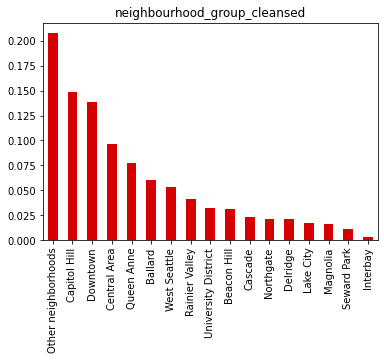

In [9]:
col = 'neighbourhood_group_cleansed'
vals = df_listing_clean[col].value_counts(dropna=False)
(vals/df_listing_clean.shape[0]).plot(kind="bar")
plt.title(col)
plt.show()

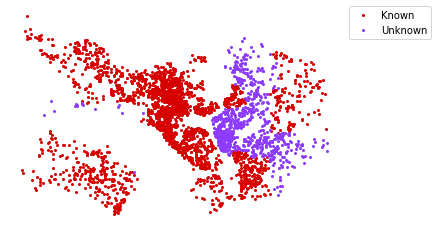

In [10]:
# Where are the 'Other Neighbourhoods' properties located on the map
groups = df_listing_clean.groupby('neighbourhood_group_cleansed_new')
for name, group in groups:
    plt.plot(group.latitude, group.longitude, marker='o', linestyle='', markersize=2, label=name)

plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad=0)

plt.axis('off');

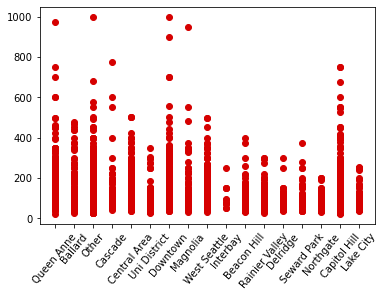

In [11]:
fig,ax = plt.subplots()
ax.scatter(x=df_listing_clean['neighbourhood_group_cleansed_new2' ], y=df_listing_clean ['price_new'])
ax.tick_params(axis="x", rotation=50)
# Like to look at raw data - can see outliers

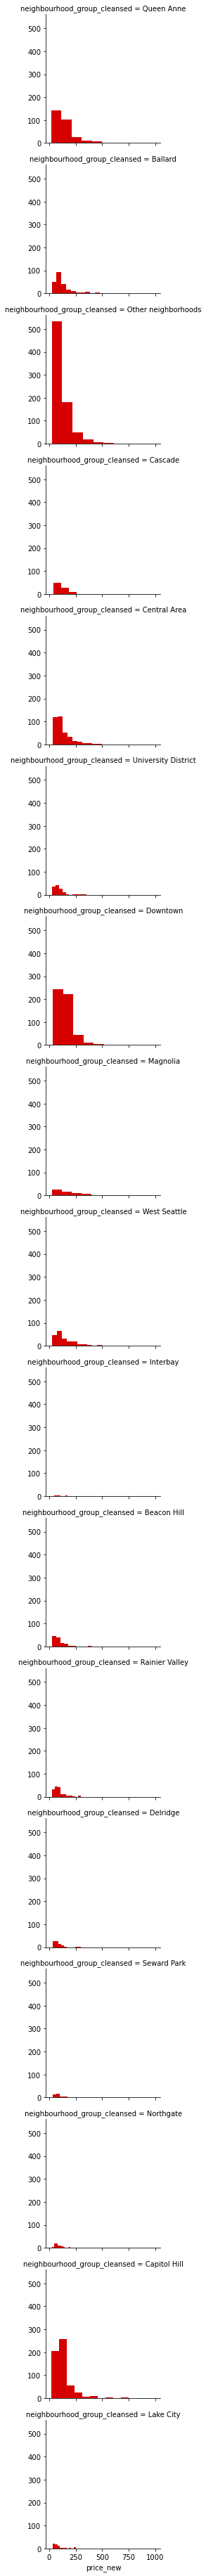

In [12]:
graph = sns.FacetGrid(data = df_listing_clean
                     , row = 'neighbourhood_group_cleansed'
#                      , col = 'neighbourhood_group_cleansed'
                     );
graph.map(plt.hist, 'price_new', bins=10);

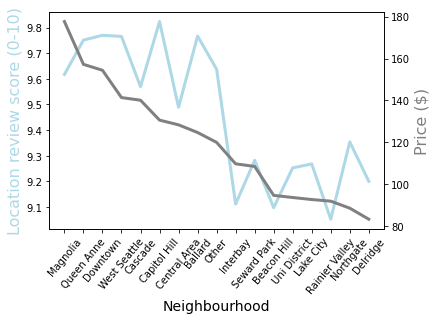

In [13]:
df_listing_des = df_listing_loc.groupby('neighbourhood_group_cleansed_new2').describe().sort_values(by=('price_new', 'mean'), ascending=False)
# Code below adapted from https://www.statology.org/matplotlib-two-y-axes/

#define colors to use
col1 = 'lightblue'
col2 = 'grey'

#define subplots
fig,ax = plt.subplots();

#add first line to plot
ax.plot(df_listing_des.index.values, df_listing_des[('review_scores_location', 'mean')], linewidth=3, color = col1)

#add x-axis label
ax.set_xlabel('Neighbourhood', fontsize=14)
ax.tick_params(axis="x", rotation=50)

#add y-axis label
ax.set_ylabel('Location review score (0-10)', color=col1, fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(df_listing_des.index.values, df_listing_des[('price_new', 'mean')], linewidth=3, color = col2)

#add second y-axis label
ax2.set_ylabel('Price ($)', color=col2, fontsize=16);

# Considered showing this graph but plotted by lon, lat gives better visual

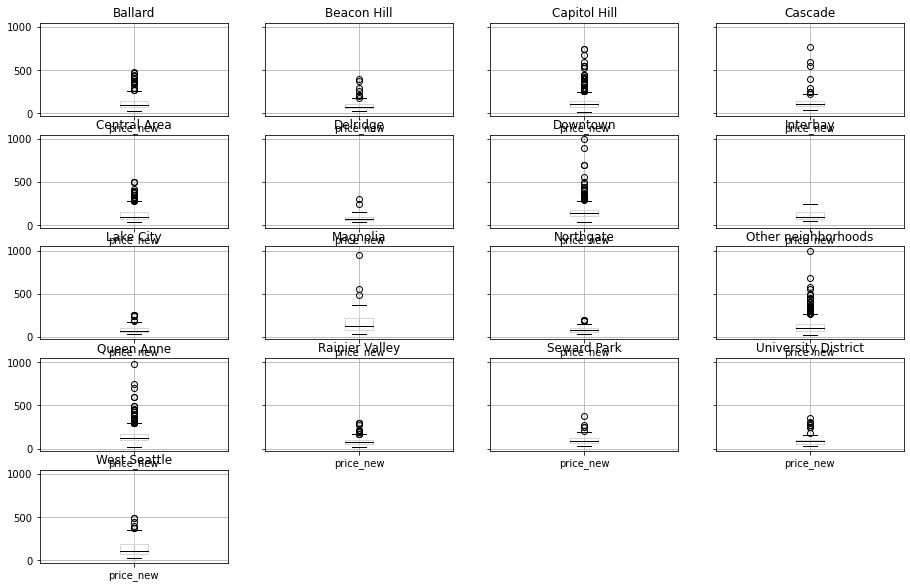

In [14]:
# box plots
df_listing_loc.groupby("neighbourhood_group_cleansed").boxplot(column="price_new", figsize=(15, 10));

# Not really that useful - I think because price data is quite skewed and so lots of outliers.

In [15]:
# Define centerpoint of the neighbourhood so that we can visualise AVG price on the map
df_listing_des

price_new                                \
                                      count        mean         std   min   
neighbourhood_group_cleansed_new2                                           
Magnolia                               61.0  177.672131  150.078726  30.0   
Queen Anne                            295.0  157.223729  115.863385  20.0   
Downtown                              530.0  154.405660   90.902800  35.0   
West Seattle                          203.0  141.359606   89.147801  30.0   
Cascade                                89.0  140.101124  112.179042  42.0   
Capitol Hill                          567.0  130.592593   92.442331  22.0   
Central Area                          369.0  128.338753   80.260558  35.0   
Ballard                               230.0  124.682609   87.925033  25.0   
Other                                 794.0  119.968514   86.580450  25.0   
Interbay                               11.0  109.727273   60.003485  50.0   
Seward Park                            44.0  108.477273   71.718276  34.0   
Beacon Hill                           118.0   94.669492   61.528682  30.0   
Uni District                          122.0   93.639344   59.721816  28.0   
Lake City                              67.0   92.671642   57.212625  35.0   
Rainier Valley                        159.0   91.899371   52.505599  25.0   
Northgate                              80.0   88.550000   38.642110  30.0   
Delridge                               79.0   83.278481   41.797110  35.0   

                                                                latitude  \
                                     25%    50%     75%     max    count   
neighbourhood_group_cleansed_new2                                          
Magnolia                            78.0  129.0  225.00   950.0     61.0   
Queen Anne                          95.0  119.0  175.00   975.0    295.0   
Downtown                           105.0  139.0  175.00   999.0    530.0   
West Seattle                        79.0  109.0  195.00   495.0    203.0   
Cascade                             88.0  115.0  141.00   775.0     89.0   
Capitol Hill                        80.0  105.0  150.00   750.0    567.0   
Central Area                        75.0  100.0  155.00   500.0    369.0   
Ballard                             70.0   95.0  149.00   475.0    230.0   
Other                               66.0   99.0  145.00  1000.0    794.0   
Interbay                            72.0   90.0  150.00   250.0     11.0   
Seward Park                         65.0   93.0  118.00   375.0     44.0   
Beacon Hill                         60.0   75.0  107.25   399.0    118.0   
Uni District                        53.5   85.0  105.00   350.0    122.0   
Lake City                           55.0   70.0  108.00   252.0     67.0   
Rainier Valley                      58.5   80.0  105.00   300.0    159.0   
Northgate                           59.0   79.5  108.25   200.0     80.0   
Delridge                            55.0   72.0   98.00   300.0     79.0   

                                                                              \
                                        mean       std        min        25%   
neighbourhood_group_cleansed_new2                                              
Magnolia                           47.649268  0.006779  47.631495  47.646538   
Queen Anne                         47.634047  0.008271  47.618762  47.627422   
Downtown                           47.611406  0.004710  47.593862  47.608426   
West Seattle                       47.561976  0.018484  47.505088  47.553779   
Cascade                            47.633757  0.008984  47.619072  47.625472   
Capitol Hill                       47.623578  0.007176  47.613138  47.618693   
Central Area                       47.607715  0.008595  47.576696  47.602387   
Ballard                            47.674525  0.006443  47.663365  47.669469   
Other                              47.670646  0.024238  47.521168  47.658673   
Interbay    

In [16]:
col_price_mean =  df_listing_des[('price_new', 'mean')].values.tolist()
col_latitude =  df_listing_des[('latitude', 'mean')].values.tolist()
col_longitude =  df_listing_des[('longitude', 'mean')].values.tolist()

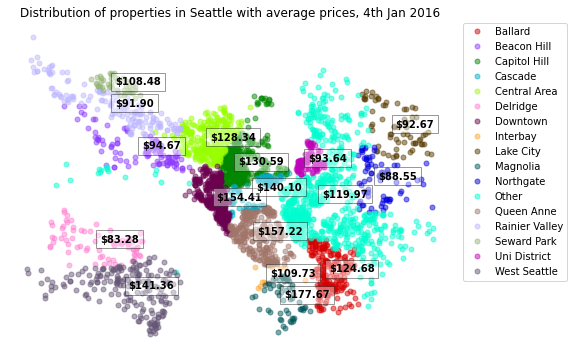

In [17]:
# Plot latitude and longitude to get an idea of distribution of properties across seattle
groups = df_listing_clean.groupby('neighbourhood_group_cleansed_new2')

plt.figure(figsize=(8, 6))

for name, group in groups:
    plt.plot(group.latitude, group.longitude, marker='o', linestyle='', markersize=5, label=name, alpha=0.5 )

plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad=0)

plt.axis('off');

# Next add on the average prices.
for i in range(0, len(col_longitude)):
    lat  = col_latitude[i]
    long = col_longitude[i]
    currency_string = "${:,.2f}".format(col_price_mean[i])

    plt.text(lat, long,currency_string, fontdict=dict(fontsize=10, fontweight='bold'), bbox=dict(facecolor='white', alpha=0.4, edgecolor='black'))
    
plt.title('Distribution of properties in Seattle with average prices, 4th Jan 2016');

## Plot data on a map using folium - *experimenting*

In [18]:
# https://stackoverflow.com/questions/64074000/create-a-new-column-from-results-in-folium
# https://python.plainenglish.io/using-folium-to-map-latitude-and-longitude-491f8dcc81ad

latitude = 47.608013 
longitude = -122.335167

url = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/neighborhoods.geojson"

seattle_map = folium.Map(location = [latitude, longitude], zoom_start = 13)

folium.GeoJson(
    url,
    name='zip_code'
).add_to(seattle_map)

for i, row in df_listing_clean.iterrows():
    lat = df_listing_clean.at[i, 'latitude']
    lng = df_listing_clean.at[i, 'longitude']
    
    if df_listing_clean.at[i, 'neighbourhood_group_cleansed'] == 'Other neighborhoods':
            col = 'lightblue'
    elif df_listing_clean.at[i, 'neighbourhood_group_cleansed'] == 'Capitol Hill':
            col = 'orange'        
    elif df_listing_clean.at[i, 'neighbourhood_group_cleansed'] == 'Downtown':
            col = 'beige'  
    else:
        col = 'pink' 
#    etc
    
    folium.Marker(location = [lat, lng], icon =  folium.Icon(color=col)  ).add_to(seattle_map)

seattle_map.save('test_map_properties.html')